Loading intrinsic population
Loading GW population
Loading EM population (GRB afterglow)

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero 

Computing GW limiting thresholds
Computing GRB AFTERGLOW limiting thresholds


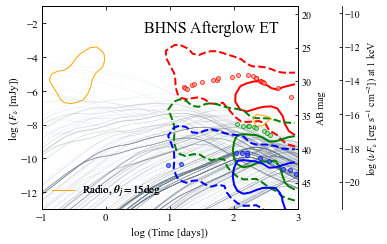

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
from functions_ET import *
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import *
import random
import warnings
warnings.filterwarnings("ignore")

num = 1000000
eos = "SFHo"

table = h5py.File('../horizons2/population/computed_population/bhns_%i_%s_z10_mass_spin_thv_GWFAST_ET.hdf5' %(num,eos),'r')

DCOtype = 'BHNS'
poptype  = 'A'
path = '../horizons2/importance_sampling/mass_rate/ET_COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5'

distribution = 'NOT fixed'   # oppure 'fixed'
spin_prescription = 'Zero'   # oppure 'Qin21' o 'Uniform'

if poptype == 'A':
    w_type, r0 = 'w_000', 94
    w_type_high, r0_high = 'w_000', 203
    w_type_low,  r0_low  = 'w_000', 30
elif poptype == 'B':
    w_type, r0 = 'w_000', 20
    w_type_high, r0_high = 'w_000', 100
    w_type_low,  r0_low  = 'w_312', 10

### --- Loading Population --- ###
print("Loading intrinsic population")
mbh     = table['mbh'][()]
mns     = table['mns'][()]
spin_bh = table['spin_bh'][()]
z       = table['z'][()]
dL      = table['dL'][()]
thv     = table['thv'][()]
m_dyn   = table['m_dyn'][()]
m_disk  = table['m_disk'][()]
m_out   = table['m_out'][()]
Ec      = table['Ec'][()]

print("Loading GW population")
snr_ETT = table['snr_ETT'][()]

print("Loading EM population (GRB afterglow)")
grb_nu  = table['grb_nu'][()]
t_grb   = np.logspace(-1, 3, 50)
lc_grb  = table['lc_grb'][()]
table.close()

### --- Weights --- ###
spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2 = spin.Bavera21()
elif spin_prescription == 'Qin21':
    spinM1, spinM2 = spin.Qin21()
elif spin_prescription == 'Uniform':
    spinM1, spinM2 = spin.Bavera21()
    spinM1 = np.random.uniform(0., 0.5, spinM1.shape)
    spinM2 = np.random.uniform(0., 0.5, spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2 = spin.Bavera21()
    spinM1 = np.zeros(spinM1.shape)
    spinM2 = np.zeros(spinM2.shape)

bhx = [2.5, 27]
nsx = [1.1, 3]
spinx = [0., 1.]
binsx = 50
binsy = 50
binsz = 50


if distribution == 'NOT fixed':
    table_w = h5py.File('../horizons2/population/computed_population/weight/w_bhns_%s_%s_notfixed.hdf5' %(eos,spin_prescription),'r')
    C_mc = table_w['C_mc'][()]
    C_mc_low = table_w['C_mc_low'][()]
    C_mc_high = table_w['C_mc_high'][()]
    w = table_w['w'][()]
    w_low = table_w['w_low'][()]
    w_high = table_w['w_high'][()]
    table_w.close()


print("\nEoS:", eos)
print("Population model:", poptype)
print("The mass and spin distributions are", distribution)
print("The spin prescription is:", spin_prescription, "\n")

### --- Limiting Thresholds --- ###
lim_snr = 12
lim_grb = np.asarray([0.1, 5.7e-3, 1.5e-6])

# GW
print("Computing GW limiting thresholds")
gw_det_ET = snr_ETT >= lim_snr

# GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det  = np.zeros([num, len(grb_nu)], dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:, j] = grb_peak[:, j, 0] >= lim_grb[j]

### --- Plot --- ###
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.figsize'] = (5.3, 3.5)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["axes.axisbelow"] = False
fig, ax1 = plt.subplots()

# Sample di LC
random.seed(0)
ind = np.arange(num, dtype=int)
ran = random.choices(ind,
                     weights=w*(m_disk>0.)*gw_det_ET*(Ec[:,0]>0)*(m_disk>1.e-4),
                     k=500)
for idx in ran:
    plt.plot(np.log10(t_grb), np.log10(lc_grb[idx, 1, :, 0]),
             c="slategray", linewidth=0.6, alpha=0.1, zorder=1)

# Picchi e contorni
color_grb = [['red','red'], ['green','green'], ['blue','blue']]
t_peak = t_grb[np.argmax(lc_grb, axis=2)]
for i in range(len(grb_nu)):
    grb_peak_nu = grb_peak[:, i, 0]
    mask = (Ec[:,0] > 0) & (m_disk > 1.e-4)
    H, xedges, yedges = np.histogram2d(
        np.log10(t_peak[mask, i, 0]),
        np.log10(grb_peak_nu[mask]),
        weights=(w*gw_det_ET)[mask],
        bins=40
    )
    g = gf(H, 1.2)
    gr = g.ravel()
    s = np.argsort(gr)
    cr = np.empty(gr.shape)
    cr[s] = np.cumsum(gr[s])
    c = np.reshape(cr/cr.max(), g.shape)

    xcentre = 0.5*(xedges[:-1] + xedges[1:])
    ycentre = 0.5*(yedges[:-1] + yedges[1:])
    T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax1.contour(T, M, c, levels=[0.1, 0.5],
                colors=color_grb[i], linestyles=['--','-'],
                linewidths=2., zorder=2)

# Caso aggiuntivo (radio, theta_j=15°)
grb_peak_nu = grb_peak[:, 0, 1]
t_peak      = t_grb[np.argmax(lc_grb, axis=2)]
t_peak_nu   = t_peak[:, 0, 1]
mask = grb_peak_nu > 0
H, xedges, yedges = np.histogram2d(
    np.log10(t_peak_nu[mask]),
    np.log10(grb_peak_nu[mask]),
    weights=(w*gw_det_ET)[mask],
    bins=40
)
g = gf(H, 1.2)
gr = g.ravel()
s = np.argsort(gr)
cr = np.empty(gr.shape); cr[s] = np.cumsum(gr[s])
c = np.reshape(cr/cr.max(), g.shape)
xcentre = 0.5*(xedges[:-1] + xedges[1:])
ycentre = 0.5*(yedges[:-1] + yedges[1:])
T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
ax1.contour(T, M, c, levels=[0.5], colors="orange", linestyles='-', linewidths=1., zorder=2)

ax1.set_xlabel(r'log (Time [days])', size=11)
ax1.set_ylabel(r'log ($F_\nu$ [mJy])', size=11, labelpad=0.1)
ax1.set_ylim((-13, -1))
ax1.set_xlim((-1, 3))

# GRB170817A (riscalato alla distanza mediana della popolazione)
t_x, f_x, grb170817_x, errhigh_x, errlow_x = np.loadtxt("./GRB170817A/afterglow_x.txt", usecols=[0,1,2,3,4], unpack=True)
t_r, f_r, grb170817_r, err_r = np.loadtxt("./GRB170817A/afterglow_r.txt", usecols=[0,1,2,3], unpack=True)
t_o, f_o, grb170817_o, err_o = np.loadtxt("./GRB170817A/afterglow_o.txt", usecols=[0,1,2,3], unpack=True)

W = w * gw_det_ET
s = np.argsort(dL)
dL_cdf = np.cumsum(W[s]); dL_cdf /= dL_cdf[-1]
dL0 = np.sort(dL)
dL_median = np.interp(0.5, dL_cdf, dL0)
scale_dis = (dL_median**2) / (42**2)

after_x = grb170817_x * 1.e-3 / scale_dis
plt.errorbar(np.log10(t_x), np.log10(after_x),
             markersize=4, markerfacecolor="royalblue", color='blue',
             ls='None', marker='o', zorder=2, alpha=0.7)

after_o = grb170817_o * 1.e-3 / scale_dis
plt.errorbar(np.log10(t_o), np.log10(after_o),
             markersize=4, markerfacecolor="lightgreen", color='green',
             ls='None', marker='o', zorder=2, alpha=0.7)

after_r = grb170817_r * 1.e-3 / scale_dis
plt.errorbar(np.log10(t_r), np.log10(after_r),
             markersize=4, markerfacecolor="lightsalmon", color='red',
             ls='None', marker='o', zorder=2, alpha=0.7)

leg2 = plt.legend([Line2D([0],[0],color='orange',lw=1,ls="-")],
                  [r'Radio, $\theta_j=15$deg'],
                  loc=3, frameon=False, prop={'size': 11})
plt.gca().add_artist(leg2)

plt.text(0.6, -2.5, "BHNS Afterglow ET", size=16)
plt.tick_params(direction='in', left=True, bottom=True, top=True, right=True, labelsize=11, zorder=7)

# Assi secondari
ax2 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax2.set_ylim(mJy_to_ABmag(10**mn), mJy_to_ABmag(10**mx))
ax2.set_ylabel('AB mag', size=10)
plt.tick_params(direction='in', right=True, labelsize=10, zorder=7)

ax3 = ax1.twinx()
mn, mx = ax1.get_ylim()
ax3.set_ylim(np.log10(2.41e17 * 1.e-26 * (10**mn)),
             np.log10(2.41e17 * 1.e-26 * (10**mx)))
ax3.set_ylabel(r'log ($\nu F_\nu$ [erg s$^{-1}$ cm$^{-2}$]) at 1 keV', size=10)
ax3.spines["right"].set_position(("axes", 1.17))
plt.tick_params(direction='in', right=True, labelsize=10, zorder=7)

plt.subplots_adjust(right=0.6)
plt.show()
